# Collaborative Filtering-based recommendation system

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Load MovieLens data
def load_data(filepath="ml-1m/ratings.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python", 
                     names=["userId", "movieId", "rating", "timestamp"])
    df = df.drop(columns=["timestamp"])  # Remove timestamp for CF
    return df

ratings_df = load_data()
print(f"Loaded {len(ratings_df)} ratings.")

# Encode users and movies into unique indices
user_ids = {user: idx for idx, user in enumerate(ratings_df["userId"].unique())}
movie_ids = {movie: idx for idx, movie in enumerate(ratings_df["movieId"].unique())}

# Map users and movies to indices
ratings_df["userId"] = ratings_df["userId"].map(user_ids)
ratings_df["movieId"] = ratings_df["movieId"].map(movie_ids)

# Train-test split (80% train, 20% test)
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)

print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")


Loaded 1000209 ratings.
Train size: 800167, Test size: 200042


In [3]:
# Define CF-based Matrix Factorization Model
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=50):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)

    def forward(self, user_ids, movie_ids):
        user_vecs = self.user_embedding(user_ids)  # (batch_size, embedding_dim)
        movie_vecs = self.movie_embedding(movie_ids)  # (batch_size, embedding_dim)
        dot_product = (user_vecs * movie_vecs).sum(-1)  # Compute rating scores
        pred_ratings = dot_product + self.user_bias(user_ids).squeeze() + self.movie_bias(movie_ids).squeeze()
        return pred_ratings  # Shape should be (batch_size,) or (batch_size, num_movies)



In [4]:
# PyTorch Dataset for CF
class CF_Dataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df["userId"].values, dtype=torch.long)
        self.movies = torch.tensor(df["movieId"].values, dtype=torch.long)
        self.ratings = torch.tensor(df["rating"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

# Create train and test DataLoaders
train_dataset = CF_Dataset(train_data)
test_dataset = CF_Dataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


Epoch 1, Loss: 18.8715
Epoch 2, Loss: 1.6228
Epoch 3, Loss: 0.9619
Epoch 4, Loss: 0.9629
Epoch 5, Loss: 0.9620
Epoch 6, Loss: 0.9543
Epoch 7, Loss: 0.9488
Epoch 8, Loss: 0.9444
Epoch 9, Loss: 0.9416
Epoch 10, Loss: 0.9388
Epoch 11, Loss: 0.9364
Epoch 12, Loss: 0.9344
Epoch 13, Loss: 0.9333
Epoch 14, Loss: 0.9318
Epoch 15, Loss: 0.9300
Epoch 16, Loss: 0.9303
Epoch 17, Loss: 0.9279
Epoch 18, Loss: 0.9279
Epoch 19, Loss: 0.9277
Epoch 20, Loss: 0.9276


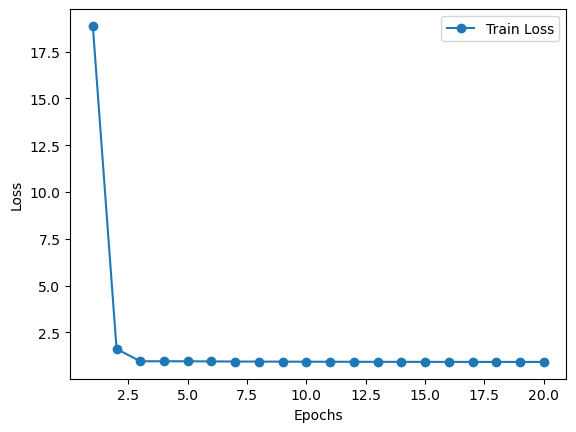

In [5]:
# Train function for Matrix Factorization
def train_cf(model, train_loader, epochs=5, lr=0.005):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # Added L2 regularization
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for users, movies, ratings in train_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            optimizer.zero_grad()
            predictions = model(users, movies)
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Plot loss curve
    import matplotlib.pyplot as plt
    plt.plot(range(1, epochs+1), losses, marker='o', label='Train Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


# Initialize and Train CF Model
num_users = len(user_ids)
num_movies = len(movie_ids)
cf_model = MatrixFactorization(num_users, num_movies).to(device)

train_cf(cf_model, train_loader, epochs=20)


In [6]:
import torch.nn.functional as F

# Compute Recall@K
def recall_at_k(top_k_predictions, targets, k):
    """
    Computes Recall@K by checking how often the true movie appears in the top-K predictions.
    """
    targets = targets.view(-1, 1).expand(-1, k)  # Expand targets to (batch_size, K)
    hits = (top_k_predictions == targets).float()  # Check if true movie is in top-K
    recall = hits.sum(dim=-1).mean().item()  # Compute recall
    return recall

# Compute NDCG@K
def ndcg_at_k(top_k_predictions, targets, k):
    """
    Computes NDCG@K by measuring ranking quality of the predicted recommendations.
    """
    targets = targets.view(-1, 1).expand(-1, k)  # Expand targets for broadcasting
    hits = (top_k_predictions == targets).float()
    log_positions = 1 / torch.log2(torch.arange(2, k + 2, device=targets.device).float())  # Discount factor
    dcg = (hits * log_positions).sum(dim=-1).mean().item()
    return dcg



# Evaluate CF model
def evaluate_cf(model, test_loader, all_movie_ids, k=10):
    model.eval()
    total_loss = 0
    total_recall = 0
    total_ndcg = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for batch_idx, (users, movies, ratings) in enumerate(test_loader):
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)

            # Get all possible movie predictions
            all_movies = torch.tensor(all_movie_ids, dtype=torch.long, device=device).expand(users.shape[0], -1)
            users_expanded = users.unsqueeze(1).expand(-1, all_movies.shape[1])  
            
            predictions = model(users_expanded, all_movies)  # Expected shape (batch_size, num_movies)

            # Debug: Print first user's top predictions
            if batch_idx == 0:
                top_k_values, top_k_predictions = torch.topk(predictions, k, dim=-1)
                print(f"User {users[0].item()} Top-10 Predictions (Movie IDs): {top_k_predictions[0].tolist()}")
                print(f"User {users[0].item()} Predicted Scores: {top_k_values[0].tolist()}")

            # Compute RMSE
            loss = criterion(model(users, movies), ratings)
            total_loss += loss.item()

            # Get top-K recommendations
            _, top_k_predictions = torch.topk(predictions, k, dim=-1)

            # Compute Recall@K & NDCG@K
            recall = recall_at_k(top_k_predictions, movies, k)
            ndcg = ndcg_at_k(top_k_predictions, movies, k)

            total_recall += recall
            total_ndcg += ndcg

    # Compute averages
    rmse = (total_loss / len(test_loader)) ** 0.5
    avg_recall = total_recall / len(test_loader)
    avg_ndcg = total_ndcg / len(test_loader)

    print(f"CF Test RMSE: {rmse:.4f}, Recall@{k}: {avg_recall:.4f}, NDCG@{k}: {avg_ndcg:.4f}")
    return rmse, avg_recall, avg_ndcg

In [7]:
# Get all movie IDs for ranking in CF
all_movie_ids = list(movie_ids.values())

# Run CF evaluation
rmse_cf, recall_cf, ndcg_cf = evaluate_cf(cf_model, test_loader, all_movie_ids, k=10)


User 5411 Top-10 Predictions (Movie IDs): [259, 669, 29, 104, 611, 0, 629, 128, 1092, 831]
User 5411 Predicted Scores: [5.096291542053223, 5.067940711975098, 4.992334365844727, 4.977322578430176, 4.973267078399658, 4.943129539489746, 4.868364334106445, 4.865688323974609, 4.83309268951416, 4.821764945983887]
CF Test RMSE: 0.9724, Recall@10: 0.0244, NDCG@10: 0.0114
